In [3]:
import boto3
import pandas as pd
import numpy as np
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

### data

In [2]:
client = boto3.client('s3')

In [3]:
s3_prefix = 's3://'
bucket = 'sisyphus-general-bucket'
primary_folder = 'AthenaInsights'
data_folder = 'latest_data'

In [5]:
response = client.list_objects_v2(
    Bucket=bucket,
    Prefix=f'{primary_folder}/{data_folder}/feature_prep/')

In [6]:
files = []
all_symbols = set()

In [13]:
paths = []
for content in response.get('Contents', []):
    # print(f"{s3_prefix}{bucket}/{content['Key']}")
    if '_rsi' not in content['Key'] and '_macd' not in content['Key']:
        paths.append(f"{s3_prefix}{bucket}/{content['Key']}")

In [14]:
paths

['s3://sisyphus-general-bucket/AthenaInsights/latest_data/feature_prep/stock_bars_100D.parquet',
 's3://sisyphus-general-bucket/AthenaInsights/latest_data/feature_prep/stock_bars_100D_base.parquet',
 's3://sisyphus-general-bucket/AthenaInsights/latest_data/feature_prep/stock_bars_100D_diff.parquet',
 's3://sisyphus-general-bucket/AthenaInsights/latest_data/feature_prep/stock_bars_10D.parquet',
 's3://sisyphus-general-bucket/AthenaInsights/latest_data/feature_prep/stock_bars_10D_base.parquet',
 's3://sisyphus-general-bucket/AthenaInsights/latest_data/feature_prep/stock_bars_10D_diff.parquet',
 's3://sisyphus-general-bucket/AthenaInsights/latest_data/feature_prep/stock_bars_10min.parquet',
 's3://sisyphus-general-bucket/AthenaInsights/latest_data/feature_prep/stock_bars_10min_base.parquet',
 's3://sisyphus-general-bucket/AthenaInsights/latest_data/feature_prep/stock_bars_10min_diff.parquet',
 's3://sisyphus-general-bucket/AthenaInsights/latest_data/feature_prep/stock_bars_120min.parquet'

### eda

In [15]:
paths_to_explore = ['s3://sisyphus-general-bucket/AthenaInsights/latest_data/feature_prep/stock_bars_60min.parquet',
                    's3://sisyphus-general-bucket/AthenaInsights/latest_data/feature_prep/stock_bars_60min_base.parquet',
                    's3://sisyphus-general-bucket/AthenaInsights/latest_data/feature_prep/stock_bars_60min_diff.parquet']

In [16]:
df = pd.read_parquet(paths_to_explore[0])
df1 = pd.read_parquet(paths_to_explore[1])
df2 = pd.read_parquet(paths_to_explore[2])

In [19]:
df1.columns
df1.symbol.unique()

array(['DAX', 'DJIA', 'QQQ', 'SPY', 'VIXM'], dtype=object)

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

In [47]:
corr = df[(df.symbol=='SPY')&(df.market_open)].drop(columns=['symbol', 'us_eastern_timestamp', 'timestamp', 'market_open', 'us_eastern_date']).corr()
corr1 = df1[(df1.symbol=='SPY')].drop(columns=['symbol', ]).corr()
corr2 = df2[(df2.symbol=='SPY')].drop(columns=['symbol', ]).corr()

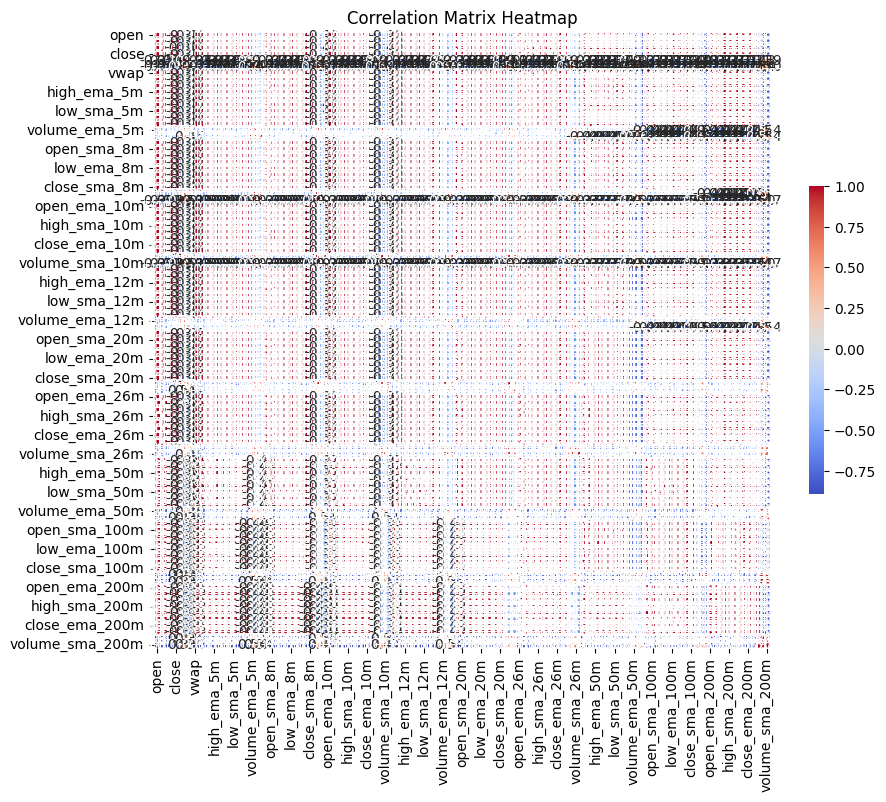

In [48]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
corr_pairs = corr.unstack()
corr_pairs = corr_pairs.sort_values(ascending=False)
high_corr_pairs = corr_pairs[(corr_pairs != 1) & (corr_pairs.index.get_level_values(0) < corr_pairs.index.get_level_values(1))]
result = pd.DataFrame(high_corr_pairs, columns=['correlation']).reset_index()
result.columns = ['from_col', 'to_col', 'correlation']
result

,from_col,to_col,correlation
0,close_ema_200m,open_ema_200m,0.999998
1,close_sma_200m,open_sma_200m,0.999998
2,close_ema_100m,open_ema_100m,0.999995
3,close_sma_100m,open_sma_100m,0.999995
4,close_sma_50m,open_sma_50m,0.999990
...,...,...,...
4651,low_sma_50m,volume_ema_200m,-0.890608
4652,low_sma_20m,volume_ema_200m,-0.891015
4653,low_ema_20m,volume_ema_200m,-0.891229
4654,low_sma_26m,volume_ema_200m,-0.891503


In [78]:
columns = corr.columns.tolist()
columns = list(reversed(columns))
threshold = 0.95
to_drop = set()
for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        if abs(corr.iloc[i, j]) > threshold and columns[i] not in to_drop and columns[j] not in to_drop:
            to_drop.add(columns[j])

In [80]:
[x for x in columns if x not in to_drop]

['volume_sma_200m',
 'low_sma_200m',
 'low_ema_200m',
 'low_ema_100m',
 'high_sma_100m',
 'high_sma_20m',
 'low_ema_12m',
 'high_sma_12m',
 'low_ema_8m',
 'high_sma_5m',
 'open']

### now

In [8]:
x = pd.read_parquet("s3://sisyphus-general-bucket/AthenaInsights/latest_data/data_prep/stock_bars_1min.parquet")
x.loc['2024-11-19 16:50:00']
print(x.shape) # (1160890, 149)
x = x.reset_index()[['us_eastern_timestamp', 'symbol']]

(429593, 9)


In [9]:
y = pd.read_parquet("s3://sisyphus-general-bucket/AthenaInsights/latest_data/data_prep/stock_bars_2min.parquet")
y.loc['2024-11-19 16:50:00']
print(y.shape) # (392417, 149)
y = y.reset_index()[['us_eastern_timestamp', 'symbol']]

(464640, 6)


In [18]:
x.tail(963)

,us_eastern_timestamp,symbol
428630,2024-11-18 19:57:00,SPY
428631,2024-11-18 19:58:00,SPY
428632,2024-11-18 19:59:00,SPY
428633,2024-11-19 04:00:00,SPY
428634,2024-11-19 04:01:00,SPY
...,...,...
429588,2024-11-19 19:55:00,SPY
429589,2024-11-19 19:56:00,SPY
429590,2024-11-19 19:57:00,SPY
429591,2024-11-19 19:58:00,SPY


In [24]:
y.tail(482)

,us_eastern_timestamp,symbol
464158,2024-11-19 03:56:00,SPY
464159,2024-11-19 03:58:00,SPY
464160,2024-11-19 04:00:00,SPY
464161,2024-11-19 04:02:00,SPY
464162,2024-11-19 04:04:00,SPY
...,...,...
464635,2024-11-19 19:50:00,SPY
464636,2024-11-19 19:52:00,SPY
464637,2024-11-19 19:54:00,SPY
464638,2024-11-19 19:56:00,SPY
